# ベイズ線形回帰の実装
## ボストン住宅データの解析

尤度関数は
$$
f(y|\beta, \sigma^2) = \prod_{i=1}^{n} \frac{1}{(2\pi\sigma^2)^{1/2}} \exp{\{-\frac{(y_i - x_i^{'}\beta)^2}{2\sigma^2}\}} \\
\propto (\frac{1}{\sigma^2})^{n/2} \exp{\{-\frac{\sum_{i=1}{n}(y_i - x_i^{'}\beta)^2}{2\sigma^2}\}}
$$
であり、パラメータの事前分布は
$$
\beta \sim N(\beta_0, B_0), \quad \sigma_2 \sim IG(\frac{n_0}{2}, \frac{s_0}{2})
$$
を仮定する。この時、事後分布は
$$
\pi(\beta, \sigma^2|y) \propto (\frac{1}{\sigma^2})^{n/2} \exp{\{^\frac{\sum_{i=1}^{n}(y_i - x_i^{'}\beta)^2}{2\sigma^2}\}} \\
\times \exp{\{-\frac{1}{2}(\beta - \beta_0)^{'} B_0^{-1}(\beta - \beta_0)\}} \\
\times (\frac{1}{\sigma^2})^{n_0/2 +1} \exp{(- \frac{s_0}{2\sigma^2})}
$$

# 正則化
1. Ridge
    * パラメータ
        $\lambda$
        $$
        
        $$
2. Lasso
    * パラメータ
        $\lambda$
3. Elastic Net
    * パラメータ
        $\lambda_1, \lambda_2$
4. Group Lasso
5. Fused Lasso

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
data = load_boston()

In [3]:
names = pd.DataFrame(data=data.data,columns=data.feature_names)
print(names.iloc[1:5])
names["NOX"] = names["NOX"] ** 2
names["RM"] = names["RM"] ** 2
names["DIS"] = np.log(names["DIS"])
names["RAD"] = np.log(names["RAD"])
names["LSTAT"] = np.log(names["LSTAT"])
print(names.iloc[1:5])
names = np.array(names)


      CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  PTRATIO  \
1  0.02731  0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0     17.8   
2  0.02729  0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0     17.8   
3  0.03237  0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0     18.7   
4  0.06905  0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0     18.7   

        B  LSTAT  
1  396.90   9.14  
2  392.83   4.03  
3  394.63   2.94  
4  396.90   5.33  
      CRIM   ZN  INDUS  CHAS       NOX         RM   AGE       DIS       RAD  \
1  0.02731  0.0   7.07   0.0  0.219961  41.229241  78.9  1.602836  0.693147   
2  0.02729  0.0   7.07   0.0  0.219961  51.624225  61.1  1.602836  0.693147   
3  0.03237  0.0   2.18   0.0  0.209764  48.972004  45.8  1.802073  1.098612   
4  0.06905  0.0   2.18   0.0  0.209764  51.079609  54.2  1.802073  1.098612   

     TAX  PTRATIO       B     LSTAT  
1  242.0     17.8  396.90  2.212660  
2  242.0     17.8  392.83  

In [4]:
train_X, test_X, train_y, test_y = train_test_split(names, np.log(data.target), test_size=0.2, random_state=0)

## 線形回帰のギブスサンプリングアルゴリズム
Algorithm
1. Initialize all parameters with random values
2. for t \leftarrow 1 to iter_num then  
    1. Calculate $B^{-1}$ from  
        $$
        \hat{B}^{-1} = \sum_{i=1}^{n} \frac{x_i x_i^{'}}{\sigma^2} + B_0^{-1}
        $$
    2. Calculate $\beta$ from 
        $$
        \hat{\beta} = \hat{\beta} \left( \sum_{i=1}^{n} \frac{x_i y_i}{\sigma^2} + B_0^{-1} \beta_0 \right)
        $$
    3. Sample $\beta$ from
        $$
        \pi(\beta|\sigma^2, y) = N(\hat{\beta}, \hat{B})
        $$
    4. Sample $\sigma^2$ from
        $$
        \pi(\sigma^2|\beta, y) = IG \left( \frac{n+n_0}{2}, \frac{\sum_{i=1}^{n}(y_i - x_i^{'}\beta)^2 + s_0}{2} \right)
        $$  


* 逆ガンマ分布からのサンプリングでは、ガンマ分布でscaleパラメータの逆数をscaleとして用いた時のガンマ分布からの乱数の逆数をサンプルとする。

In [90]:
class Bayesian_Linear_Regression(object):
    """
    Implementation of inference of Linear Regression by bayesian method.
    
    Attributes
    -----------------
    
    """
    def __init__(self, mu_prior=np.zeros(13), cov_prior=100*np.identity(13), shape_prior=5, scale_prior=0.01):
        """
        Initialize parameters' priors' parameters
        
        Parameters
        -------------------
        mu_prior : the value of prior mean, default \boldsymbol{0}
        cov_prior : the value of prior covariance matrix, default 100 * I
        shape_prior : the value of shape parameter of IG distribution, default 5
        scale_prior : the value of scale parameter of IG distribution, default = 0.01
        """
        self.mu_prior = mu_prior
        self.cov_prior = cov_prior
        self.shape_prior = shape_prior
        self.scale_prior = scale_prior
        self.cov_prior_inv = np.linalg.inv(cov_prior)
        
    def gibbs_sampler(self, train_x, train_y, parameter_name=None, iter_num=4000, num_burnin=500):
        """
        Gibbs Sampler for Linear Regression
        ギブスサンプリング
        Parameters
        --------------------
        train_x : training data's features
        train_y : training data's targets
        parameter_name : the names of parameters
        iter_num : number of iteration, default 4000
        num_burnin : number of burn-in iteration, default 500
        
        Returns
        --------------------
        
        """
        self.iter_num = iter_num
        self.num_burnin = num_burnin
        self.parameter_name = parameter_name
        # settings for use numpy's "append" method
        self.beta_samples = np.empty((0, train_x.shape[1]))
        self.sigma2_samples = np.empty((0, 1))
        # Initialization of parameters
        beta = np.random.normal(size=train_x.shape[1])
        sigma2 = np.random.uniform()
        self.beta_samples = np.append(self.beta_samples, np.array([beta]), axis=0)
        self.sigma2_samples = np.append(self.sigma2_samples, np.array([[sigma2]]), axis=0)
        # Gibbs Sampler iteration
        for i in range(iter_num):
            B_inv = self.calc_B_inv(train_x, sigma2)
            beta_hat = self.calc_beta_hat(train_x, train_y, sigma2, B_inv)
            cov_tmp = np.linalg.inv(B_inv)
            beta = np.random.multivariate_normal(mean=beta_hat, cov=cov_tmp)
            residual = train_x.dot(beta) - train_y
            sigma2 = 1 / (np.random.gamma(shape=(train_x.shape[0] + self.shape_prior) / 2, 
                                                                 scale=1 / ((residual.T.dot(residual) + self.scale_prior) / 2)))
            # add sample to list
            self.beta_samples = np.append(self.beta_samples, np.array([beta]), axis=0)
            self.sigma2_samples = np.append(self.sigma2_samples, np.array([[sigma2]]), axis=0)
            
        return [self.beta_samples, self.sigma2_samples]

    def summary(self):
        return

    def calc_B_inv(self, train_x, sigma2):
        """
        Calculate the inverse of matrix B, which has k * k dimension
        """
        return train_x.T.dot(train_x) / sigma2 + self.cov_prior_inv
        
    def calc_beta_hat(self, train_x, train_y, sigma2, b_inv):
        return np.linalg.inv(b_inv).dot(train_x.T.dot(train_y) / sigma2 + self.cov_prior_inv.dot(self.mu_prior))
#         return np.linalg.inv(B_inv).dot(train_x.T.dot(train_y) + cov_pri_inv.dot(mu_pri))
    
    def trace_plot(self, sample_list, sample_name, save=True):
        """
        Visualize trace plot
        
        Parameters
        sample_list : the samples of mcmc, k * iter_num dimension
        sample_name : the names of features, default None
        """
        plt.clf()
        plt.figure(figsize=(7, 7))
        for samples, feature in zip(sample_list.T, sample_name):
            plt.plot(samples, label=feature)
            plt.title("Trace Plot")
        plt.legend()
        if save:
            plt.savefig("./traceplot.png")
        else:
            plt.show()
    
    def auto_correlation_plot(self, ):
        pass
    
    def cross_validation_predictive_distribution(self):
        pass
        

iter_num = 20000
num_burnin = 5000

In [91]:
b_lr = Bayesian_Linear_Regression()

In [92]:
samp = b_lr.gibbs_sampler(train_X, train_y, data.feature_names)

In [93]:
samp

[array([[-2.24763753e-01, -1.31109379e+00, -1.02955168e+00, ...,
          1.61284549e+00, -1.80955384e-01, -3.91109238e-02],
        [-1.73064511e-02,  2.54911165e-03,  2.58862067e-02, ...,
          3.41516698e-02,  2.31076054e-03,  1.39493177e-02],
        [-1.23875311e-02,  9.63325817e-04,  9.45905183e-03, ...,
          3.86914017e-02,  1.68007592e-03, -7.11977817e-02],
        ...,
        [-1.23800603e-02, -4.32888219e-04,  8.92154608e-03, ...,
          2.99451606e-02,  1.63937826e-03,  5.64586469e-03],
        [-1.19418148e-02,  1.51510421e-03,  1.04712577e-02, ...,
          3.60880743e-02,  1.82232784e-03, -4.73475659e-02],
        [-1.16341832e-02,  2.96171369e-03,  7.20909091e-03, ...,
          2.97594455e-02,  1.71765098e-03,  1.37168091e-03]]),
 array([[0.65072355],
        [0.11365296],
        [0.08580101],
        ...,
        [0.08412531],
        [0.08793993],
        [0.08901176]])]

<Figure size 432x288 with 0 Axes>

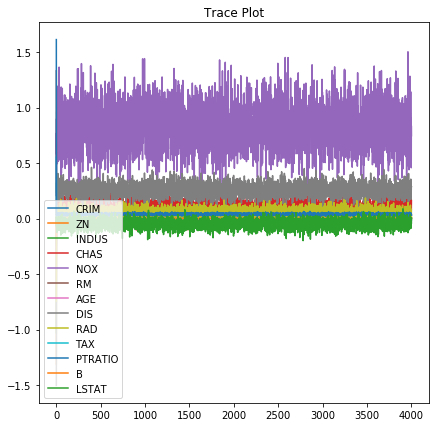

In [94]:
b_lr.trace_plot(samp[0], sample_name=data.feature_names, save=False)

In [95]:
print("Posterior Mean")
for i in range(train_X.shape[1]):
    print("{}: {}".format(data.feature_names[i], np.mean(samp[0][:, i])))
print("sigma^2: {}".format(np.mean(samp[1])))

Posterior Mean
CRIM: -0.012908527890676608
ZN: 0.0013989131955994512
INDUS: 0.0063681913296672055
CHAS: 0.09314803052836888
NOX: 0.8285686901145412
RM: 0.031897612968738435
AGE: 0.0006521958789268506
DIS: 0.25982811549786616
RAD: 0.059060479817076135
TAX: -0.0004596894103212877
PTRATIO: 0.03923404541349557
B: 0.0016281781310032752
LSTAT: -0.050136613316815556
sigma^2: 0.08328040477254983


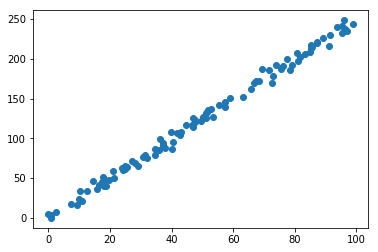

In [102]:
## 擬似データの生成
alpha = 2.5
beta = 0.8
sigma = 5
n = 100

x = np.array(np.c_[np.ones(n), np.random.rand(n) * n])
y = x[:, 1] * alpha + x[:, 0] * beta + np.random.normal(0, sigma, n)
# y = np.array(alpha * x[:,0] + beta * x[:,1] + np.random.normal(0, sigma, n))

plt.plot(x[:,1],y,'o')

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [104]:
b_lr_sim = Bayesian_Linear_Regression(mu_prior=np.zeros(2), cov_prior=10*np.identity(2))
samp_sim = b_lr_sim.gibbs_sampler(x, y)

0.14266059792303537
2.4947664058953762
26.04560846640465


<Figure size 432x288 with 0 Axes>

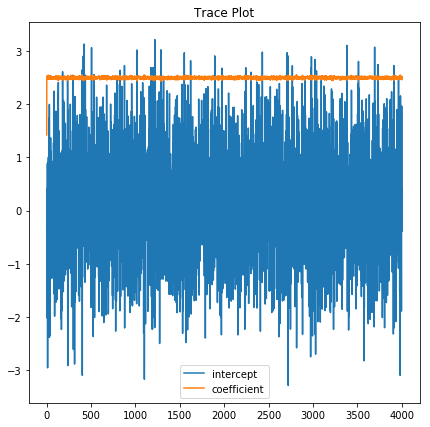

In [105]:
b_lr_sim.trace_plot(samp_sim[0], ["intercept", "coefficient"])
print(np.mean(samp_sim[0][:, 0]))
print(np.mean(samp_sim[0][:, 1]))
print(np.mean(samp_sim[1]))

<Figure size 432x288 with 0 Axes>

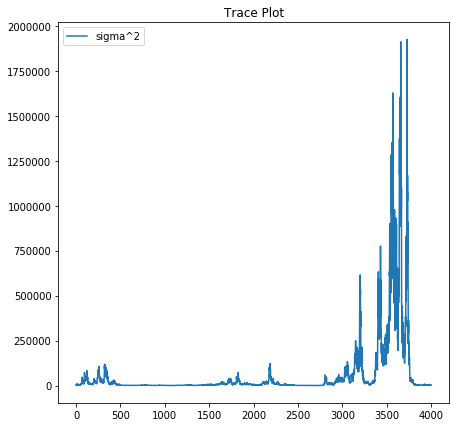

In [83]:
b_lr_sim.trace_plot(samp_sim[1], ["sigma^2"])